# Rank based Methods 

**Author: Serge Rey <sjsrey@gmail.com>, Wei Kang <weikang9009@gmail.com>**

## Introduction

This notebook introduces two classic nonparametric statistics of exchange mobility and their spatial extensions. We will demonstrate the usage of these methods by an empirical study for understanding [regional exchange mobility pattern in US](#Regional-exchange-mobility-pattern-in-US-1929-2009). The dataset is the per capita incomes observed annually from 1929 to 2010 for the lower 48 US states.

* [Kendall's $\tau$](#Kendall's-$\tau$)
    * [Classic Kendall's $\tau$](#Classic-Kendall's-$\tau$)
    * [Spatial Kendall's $\tau$](#Spatial-Kendall's-$\tau$)
    * [Inter- and Intra-regional decomposition of Kendall's $\tau$](#Inter--and-Intra-regional-decomposition-of-Kendall's-$\tau$)
    * [Local indicator of mobility association](#Local-indicator-of-mobility-association)
* [$\Theta$ statistic of exchange mobility](#$\Theta$-statistic-of-exchange-mobility)

## Regional exchange mobility pattern in US 1929-2009

Firstly we load in the US dataset:

In [1]:
from splot import mapping as maps
import pandas as pd
import libpysal
import libpysal.io.geotable as pdio
shp_link = libpysal.examples.get_path('us48.shp')
data_table = pdio.read_files(shp_link)
income_table = pd.read_csv(libpysal.examples.get_path("usjoin.csv"))
complete_table = data_table.merge(income_table,left_on='STATE_NAME',right_on='Name')
complete_table.head()

,AREA,PERIMETER,STATE_,STATE_ID,STATE_NAME,STATE_FIPS_x,SUB_REGION,STATE_ABBR,geometry,Name,...,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009
0,20.750,34.956,1,1,Washington,53,Pacific,WA,<libpysal.cg.shapes.Polygon object at 0x118018...,Washington,...,31528,32053,32206,32934,34984,35738,38477,40782,41588,40619
1,45.132,34.527,2,2,Montana,30,Mtn,MT,<libpysal.cg.shapes.Polygon object at 0x118018...,Montana,...,22569,24342,24699,25963,27517,28987,30942,32625,33293,32699
2,9.571,18.899,3,3,Maine,23,N Eng,ME,<libpysal.cg.shapes.Polygon object at 0x118018...,Maine,...,25623,27068,27731,28727,30201,30721,32340,33620,34906,35268
3,21.874,21.353,4,4,North Dakota,38,W N Cen,ND,<libpysal.cg.shapes.Polygon object at 0x118037...,North Dakota,...,25068,26118,26770,29109,29676,31644,32856,35882,39009,38672
4,22.598,22.746,5,5,South Dakota,46,W N Cen,SD,<libpysal.cg.shapes.Polygon object at 0x118037...,South Dakota,...,26115,27531,27727,30072,31765,32726,33320,35998,38188,36499


We will visualize the spatial distributions of per capita incomes in US states across 1929 to 2009 to obtain a first impression of the dynamics. 

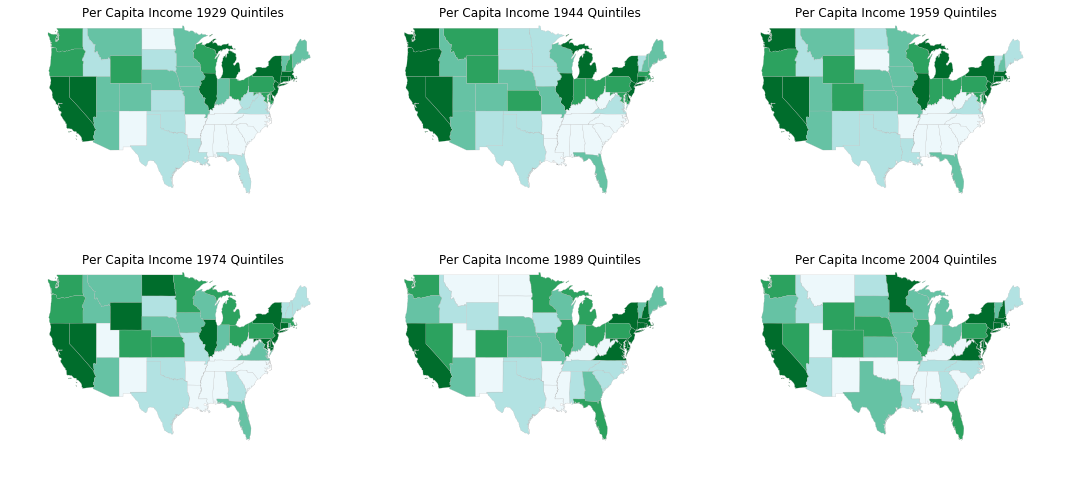

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
index_year = range(1929,2010,15)
fig, axes = plt.subplots(nrows=2, ncols=3,figsize = (15,7))
for i in range(2):
    for j in range(3):
        ax = axes[i,j]
        maps.geoplot(complete_table, col=str(index_year[i*3+j]),ax=ax,classi="Quantiles")
        ax.set_title('Per Capita Income %s Quintiles'%str(index_year[i*3+j]))
plt.tight_layout()

Blew displays trajectories of 

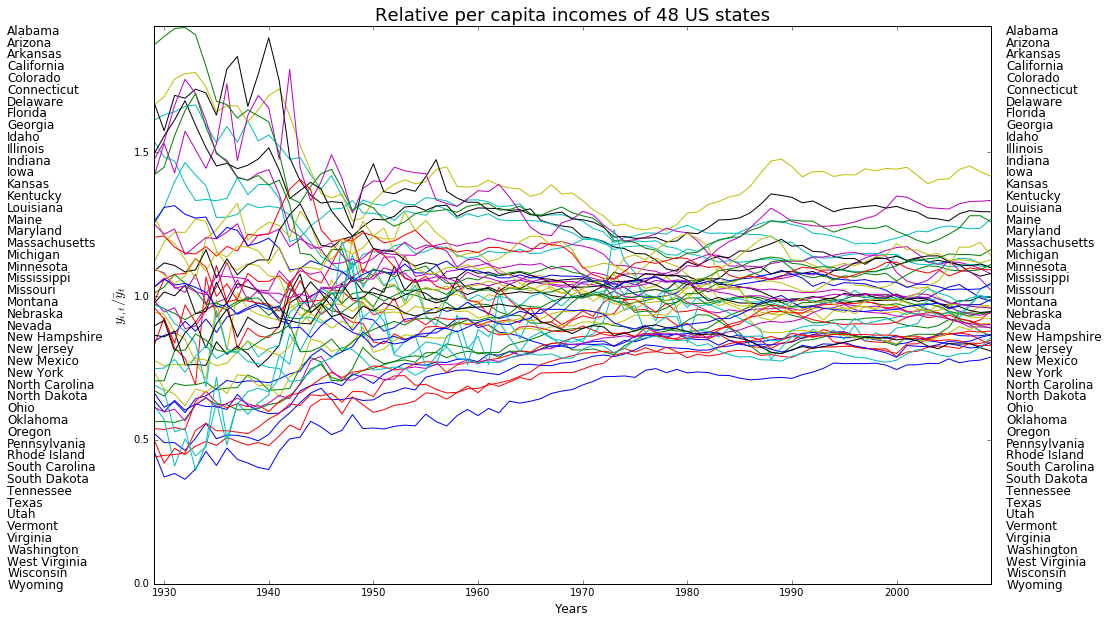

In [3]:
import numpy as np
years = range(1929,2010)
names = income_table['Name']
pci = income_table.drop(['Name','STATE_FIPS'], 1).as_matrix().T
rpci= (pci.T / pci.mean(axis=1)).T
order1929 = np.argsort(rpci[0,:])
order2009 = np.argsort(rpci[-1,:])
names1929 = names[order1929[::-1]]
names2009 = names[order2009[::-1]]
first_last = np.vstack((names[order1929[::-1]],names[order2009[::-1]]))
from pylab import rcParams
rcParams['figure.figsize'] = 15,10
p = plt.plot(years,rpci)
for i in range(48):
    plt.text(1915,1.91-(i*0.041), names1929[i],fontsize=12)
    plt.text(2010.5,1.91-(i*0.041), names2009[i],fontsize=12)
plt.xlim((years[0], years[-1]))
plt.ylim((0, 1.94))
plt.ylabel(r"$y_{i,t}/\bar{y}_t$",fontsize=14)
plt.xlabel('Years',fontsize=12)
plt.title('Relative per capita incomes of 48 US states',fontsize=18)

The above figure displays the trajectories of relative per capita incomes of 48 Mexican states. It is quite obvious that states were swapping positions across 1929-2009. We will demonstrate how to quantify the exchange mobility as well as how to assess the regional and local contribution to the overall exchange mobility. We will ultilize [BEA regions](https://www.bea.gov/regional/docs/regions.cfm) for constructing the block weight matrix. 

BEA regional scheme divide US states into 8 regions:
* New England Region
* Mideast Region
* Great Lakes Region
* Plains Region
* Southeast Region
* Southwest Region
* Rocky Mountain Region
* Far West Region

As the dataset does not contain information regarding BEA regions, we manually input the regional information.

In [4]:
BEA_regions = ["New England Region","Mideast Region","Great Lakes Region","Plains Region","Southeast Region","Southwest Region","Rocky Mountain Region","Far West Region"]
BEA_regions_abbr = ["NENG","MEST","GLAK","PLNS","SEST","SWST","RKMT","FWST"]
BEA = pd.DataFrame({ 'Region code' : np.arange(1,9,1), 'BEA region' : BEA_regions,'BEA abbr':BEA_regions_abbr})
BEA

,BEA abbr,BEA region,Region code
0,NENG,New England Region,1
1,MEST,Mideast Region,2
2,GLAK,Great Lakes Region,3
3,PLNS,Plains Region,4
4,SEST,Southeast Region,5
5,SWST,Southwest Region,6
6,RKMT,Rocky Mountain Region,7
7,FWST,Far West Region,8


In [5]:
region_code = list(np.repeat(1,6))+list(np.repeat(2,6))+list(np.repeat(3,5))+list(np.repeat(4,7))+list(np.repeat(5,12))+list(np.repeat(6,4))+list(np.repeat(7,5))+list(np.repeat(8,6))
state_code = ['09','23','25','33','44','50','10','11','24','34','36','42','17','18','26','39','55','19','20','27','29','31','38','46','01','05','12','13','21','22','28','37','45','47','51','54','04','35','40','48','08','16','30','49','56','02','06','15','32','41','53']
state_region = pd.DataFrame({'Region code':region_code,"State code":state_code})
state_region_all = state_region.merge(BEA,left_on='Region code',right_on='Region code')
complete_table = complete_table.merge(state_region_all,left_on='STATE_FIPS_x',right_on='State code')
complete_table.head()

,AREA,PERIMETER,STATE_,STATE_ID,STATE_NAME,STATE_FIPS_x,SUB_REGION,STATE_ABBR,geometry,Name,...,2004,2005,2006,2007,2008,2009,Region code,State code,BEA abbr,BEA region
0,20.750,34.956,1,1,Washington,53,Pacific,WA,<libpysal.cg.shapes.Polygon object at 0x118018...,Washington,...,34984,35738,38477,40782,41588,40619,8,53,FWST,Far West Region
1,45.132,34.527,2,2,Montana,30,Mtn,MT,<libpysal.cg.shapes.Polygon object at 0x118018...,Montana,...,27517,28987,30942,32625,33293,32699,7,30,RKMT,Rocky Mountain Region
2,9.571,18.899,3,3,Maine,23,N Eng,ME,<libpysal.cg.shapes.Polygon object at 0x118018...,Maine,...,30201,30721,32340,33620,34906,35268,1,23,NENG,New England Region
3,21.874,21.353,4,4,North Dakota,38,W N Cen,ND,<libpysal.cg.shapes.Polygon object at 0x118037...,North Dakota,...,29676,31644,32856,35882,39009,38672,4,38,PLNS,Plains Region
4,22.598,22.746,5,5,South Dakota,46,W N Cen,SD,<libpysal.cg.shapes.Polygon object at 0x118037...,South Dakota,...,31765,32726,33320,35998,38188,36499,4,46,PLNS,Plains Region


The BEA regions are visualized below:

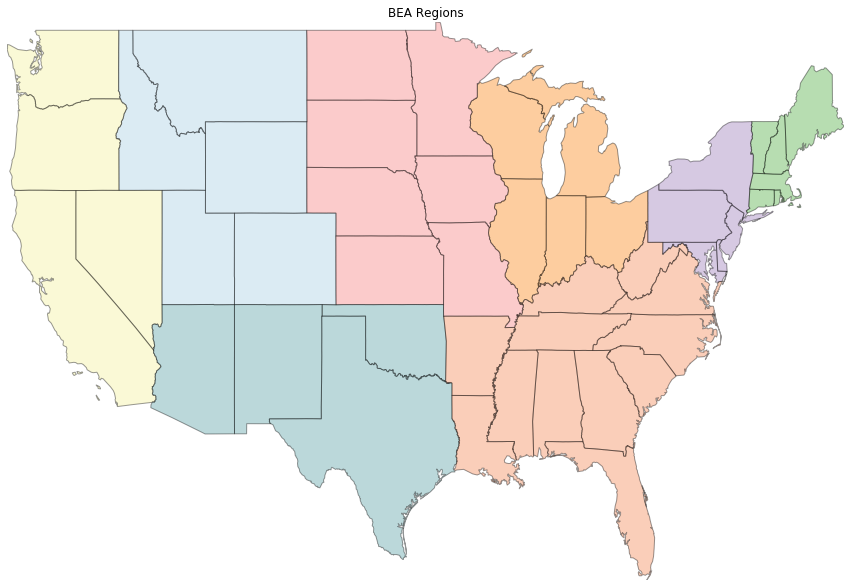

In [6]:
maps.plot_choropleth(shp_link, complete_table["BEA region"], "unique_values", title="BEA Regions")

## Kendall's $\tau$

Kendall’s $\tau$ statistic is based on a comparison of the number of pairs of $n$ observations that have concordant ranks between two variables. For measuring exchange mobility in **giddy**, the two variables in question are the values of an attribute measured at two points in time over $n$ spatial units. This classic measure of rank correlation indicates how much relative stability there has been in the map pattern over the two periods. Spatial decomposition of Kendall’s $\tau$ could be classified into three spatial scales: global spatial decomposition , inter- and intra-regional decomposition and local spatial decomposition. More details will be given latter.

### Classic Kendall's $\tau$

Kendall's $\tau$ statistic is a global measure of exchange mobility. For $n$ spatial units over two periods, it is formally defined as follows:

$$\tau = \frac{c-d}{(n(n-1))/2}$$

where $c$ is the number of concordant pairs (two spatial units which do not exchange ranks over two periods), and $d$ is the number of discordant pairs (two spatial units which exchange ranks over two periods). $-1 \leq \tau \leq 1$. Smaller $\tau$ indicates higher exchange mobility.

In giddy, class $Tau$ requires two inputs: a cross-section of income values at one period ($x$) and a cross-section of income values at another period ($y$):

```python
giddy.rank.Tau(self, x, y)
```

We will construct a $Tau$ instance by specifying the incomes in two periods. Here, we look at the global exchange mobility of US states between 1929 and 2009.

In [7]:
import giddy
giddy.rank.Tau?

In [8]:
tau = giddy.rank.Tau(complete_table["1929"],complete_table["2009"])
tau

<giddy.rank.Tau instance at 0x11bcdc758>

In [9]:
tau.concordant

856.0

In [10]:
tau.discordant

271.0

There are 856 concordant pairs of US states between 1929 and 2009, and 271 discordant pairs.

In [11]:
tau.tau

0.51884705766904615

In [12]:
tau.tau_p

1.9735720263920198e-07

The observed Kendall's $\tau$ statistic is 0.519 and its p-value is 1.974e-07. Therefore, we will reject the null hypothesis of no assocation between 1929 and 2009.

### Spatial Kendall's $\tau$

The spatial Kendall's $\tau$ decomposes all pairs into those that are spatial neighbors and those that are not, and examines whether the rank correlation is different between the two sets (Rey, 2014). 

$$\tau_w = \frac{\iota'(W\circ S)\iota}{\iota'W \iota}$$

$W$ is the spatial weight matrix, $S$ is the concordance matrix and $\iota$ is the $(n,1)$ unity vector. The null hypothesis is the spatial randomness of rank exchanges. The inference of $\tau_w$ could be conducted based on random spatial permutation of incomes at two periods.  

```python
giddy.rank.SpatialTau(self, x, y, w, permutations=0)
```
For illustration, we turn back to the case of incomes in US states over 1929-2009:

In [13]:
giddy.rank.SpatialTau?

In [14]:
import libpysal.api as ps
w = ps.block_weights(complete_table["BEA region"])
np.random.seed(12345)
tau_w = giddy.rank.SpatialTau(complete_table["1929"],complete_table["2009"],w,999) 

In [15]:
tau_w.concordant

856.0

In [16]:
tau_w.concordant_spatial

103

In [17]:
tau_w.discordant

271.0

In [18]:
tau_w.discordant_spatial

41

Out of 856 concordant pairs of spatial units, 103 belong to the same region (and are considered neighbors); out of 271 discordant pairs of spatial units, 41 belong to the same region.

In [19]:
tau_w.tau_spatial

0.43055555555555558

In [20]:
tau_w.tau_spatial_psim

0.001

The estimate of spatial Kendall's $\tau$ is 0.431 and its p-value is 0.001 which is much smaller than the significance level $0.05$. Therefore, we reject the null of spatial randomness of exchange mobility. The fact that $\tau_w=0.431$  is smaller than the global average $\tau=0.519$ implies that globally a significant number of rank exchanges happened between states within the same region though we do not know the specific region or regions hosting these rank exchanges.

### Inter- and Intra-regional decomposition of Kendall's $\tau$

### Local indicator of mobility association

## $\Theta$ statistic of exchange mobility

## Next steps

* Intra- and inter-decomposition of mobility association
* Local indicators of mobility association (LIMA)

## References
* Rey, Sergio J., and Myrna L. Sastré-Gutiérrez. 2010. “[Interregional Inequality Dynamics in Mexico](http://www.tandfonline.com/doi/abs/10.1080/17421772.2010.493955).” Spatial Economic Analysis 5 (3). Taylor & Francis: 277–98.
* Rey, Sergio J. 2014. “[Fast Algorithms for a Space-Time Concordance Measure](https://link.springer.com/article/10.1007/s00180-013-0461-2).” Computational Statistics 29 (3-4). Springer: 799–811.
* Rey, Sergio J. 2016. “[Space--Time Patterns of Rank Concordance: Local Indicators of Mobility Association with Application to Spatial Income Inequality Dynamics](http://www.tandfonline.com/doi/abs/10.1080/24694452.2016.1151336?journalCode=raag21).” Annals of the Association of American Geographers. Association of American Geographers 106 (4): 788–803.